In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


# Loading the Price Data

In [ ]:
start_date ='2015-01-01'
end_date = '2019-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

#relative_price, will calculate the change in % compared to the day before.
relative_price = (price/price.shift(1)-1)

/tmp/ipython-input-1935011397.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price = yf.download("BTC-USD", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
price.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


In [ ]:
relative_price.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN
2015-01-02,0.002492,-0.014343,-0.001395,-0.019835,-0.021888
2015-01-03,-0.107767,-0.002181,-0.103593,0.002442,3.205047
2015-01-04,-0.060079,-0.088593,-0.083499,-0.107036,0.682956
2015-01-05,0.038907,-0.030947,0.029005,-0.057130,-0.209716


In [ ]:
#add in the label
#I can start with the % change of the daily closing price, then create labels.
#another way could be to look at the next day High vs today Close.
price_2= price.Close
price['change']=price_2.apply(lambda x: x.shift(-1)/x -1)
price['change_label']=price['change'].apply (lambda x: x>0 )
#NaN > 0 gives false? Perhaps I could drop na before this step?


#copy the label to relative_price part as well.
relative_price['change'] = price['change']
relative_price['change_label']=price['change_label']

In [ ]:
print (len(price),len(relative_price))

1825 1825


In [ ]:
price = price.dropna()
relative_price = relative_price.dropna()

In [ ]:
#price would lose the last day, because no information on next day price to create the label
#relative price, would ALSO lose the first day, because no information to calculate the relative changes .
print (len(price),len(relative_price))

1824 1823


In [ ]:
relative_price[5:12]

Price,Close,High,Low,Open,Volume,change,change_label
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,
Date,,,,,,,
2015-01-07,0.028471,0.038953,0.038075,0.041754,0.069738,-0.037331,False
2015-01-08,-0.037331,-0.015461,-0.003194,0.028167,-0.196419,0.024913,True
2015-01-09,0.024913,-0.010271,-0.005819,-0.039954,-0.063250,-0.053759,False
2015-01-10,-0.053759,-0.010261,-0.023409,0.017423,-0.184538,-0.033246,False
2015-01-11,-0.033246,-0.029463,-0.032584,-0.044187,0.192377,0.008040,True
2015-01-12,0.008040,-0.026588,0.000607,-0.030815,0.037334,-0.156593,False
2015-01-13,-0.156593,-0.014423,-0.170792,0.004689,2.858196,-0.211449,False


In [ ]:
relative_price['change_label'].value_counts()

,count
change_label,
True,1000
False,823


# Adding in technical indicators

In [ ]:
price.head()

Price,Close,High,Low,Open,Volume,change,change_label
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,
Date,,,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550,0.002492,True
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,-0.107767,False
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,-0.060079,False
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,0.038907,True
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,0.042682,True


In [ ]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1

    return dataset

In [ ]:
test_df = pd.DataFrame({'B':[1,2,3,4,5,6,7]})

In [ ]:
pd.__version__

'2.2.2'

In [ ]:
price_processed = get_technical_indicators(price)
#price.head()

In [ ]:
price_processed.tail()

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2019-12-25,7275.155762,7357.020020,7220.991211,7325.755859,21559505149,-0.004974,False,7296.817801,7272.840518,7368.426134,7267.012086,-101.414048,216.709771,7706.260059,6839.420977,7296.493060
2019-12-26,7238.966797,7388.302734,7200.386719,7274.799316,22787010034,0.007062,True,7301.978167,7262.871908,7358.836553,7262.697426,-96.139127,206.236480,7675.344867,6850.398948,7258.142218
2019-12-27,7290.088379,7363.529297,7189.934082,7238.141113,22777360996,0.003827,True,7312.159877,7250.638184,7353.744096,7266.911419,-86.832677,193.541738,7637.721659,6863.554708,7279.439659
2019-12-28,7317.990234,7399.041016,7286.905273,7289.031250,21365673026,0.014302,True,7330.278669,7239.293062,7351.095662,7274.769698,-76.325964,178.778125,7596.849312,6881.736812,7305.140042
2019-12-29,7422.652832,7513.948242,7279.865234,7317.647461,22445257702,-0.017468,False,7317.573521,7232.545805,7356.396193,7297.520949,-58.875243,179.979293,7592.504391,6872.587219,7383.481902


In [ ]:
price_processed = price_processed.dropna()
price_processed.isnull().value_counts()

,,,,,,,,,,,,,,,,count
"(Close, BTC-USD)","(High, BTC-USD)","(Low, BTC-USD)","(Open, BTC-USD)","(Volume, BTC-USD)","(change, )","(change_label, )","(ma7, )","(ma21, )","(26ema, )","(12ema, )","(MACD, )","(20sd, )","(upper_band, )","(lower_band, )","(ema, )",
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1804


In [ ]:
price_processed.head()
#although I'm not very sure about how 26ema can be calculated when I don't have 26 days of data before this day ?
#and ema, with this particular set up, seems a bit off? : https://stackoverflow.com/questions/37924377/does-pandas-calculate-ewm-wrong
#the link above provides an alternate view, but I think with the amount of days I have, it shouldn't really matter that much.
#Let's keep going w/o it first.

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-01-21,226.897003,227.787994,211.212006,211.378006,29924600,0.028687,True,211.516142,252.197332,237.296354,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443
2015-01-22,233.406006,237.018997,226.434006,227.322006,33544600,-0.002258,False,214.882143,248.347666,236.943225,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152
2015-01-23,232.878998,234.845001,225.195999,233.516998,24621700,0.064274,True,218.422429,244.435617,236.580372,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049
2015-01-24,247.847000,248.210007,230.022003,232.699997,24782500,0.023688,True,225.363429,242.852998,237.571188,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350
2015-01-25,253.718002,255.074005,243.889999,247.352005,33582700,0.077862,True,231.560429,242.354093,238.971756,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451


In [ ]:
#visualise the chart
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

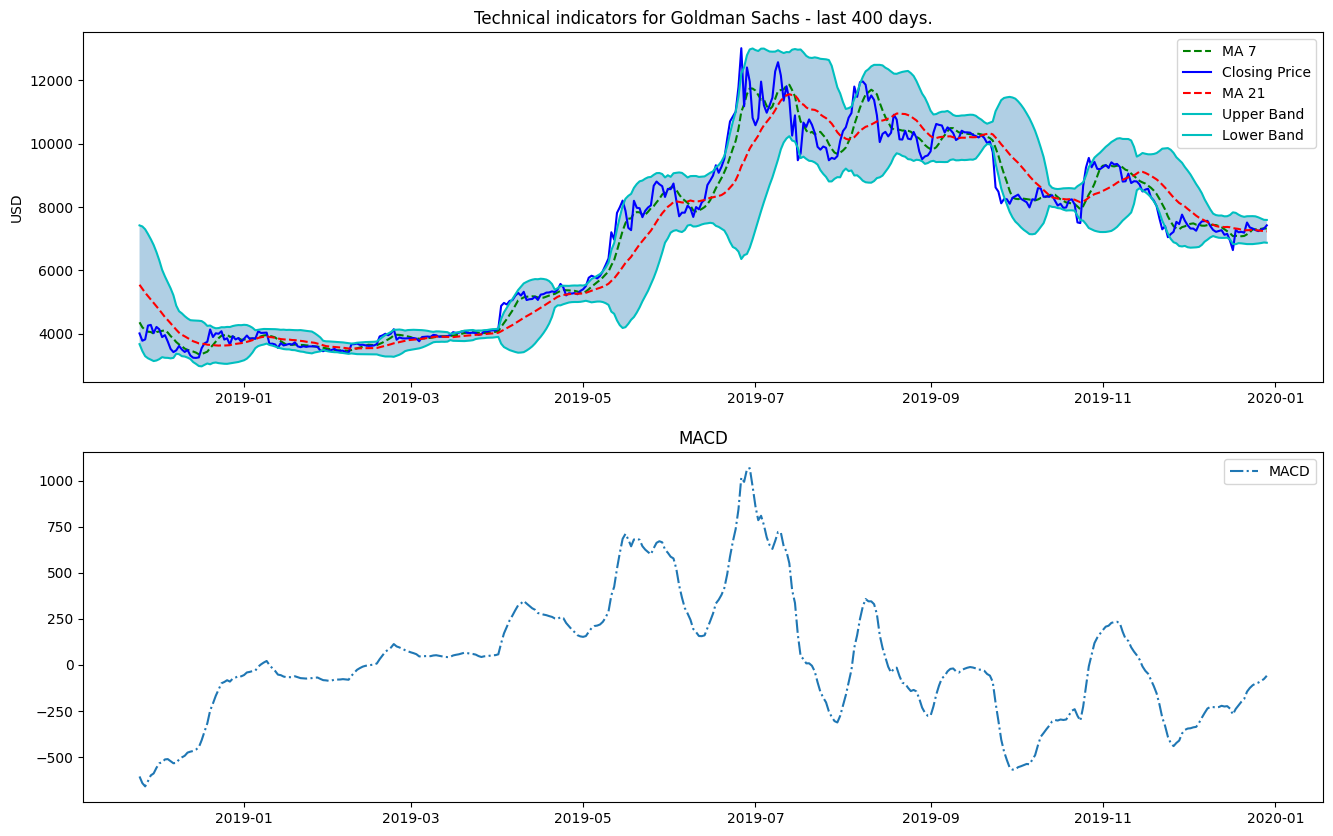

In [ ]:
plot_technical_indicators(price_processed, 400)

In [ ]:
price_processed.head()

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-01-21,226.897003,227.787994,211.212006,211.378006,29924600,0.028687,True,211.516142,252.197332,237.296354,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443
2015-01-22,233.406006,237.018997,226.434006,227.322006,33544600,-0.002258,False,214.882143,248.347666,236.943225,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152
2015-01-23,232.878998,234.845001,225.195999,233.516998,24621700,0.064274,True,218.422429,244.435617,236.580372,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049
2015-01-24,247.847000,248.210007,230.022003,232.699997,24782500,0.023688,True,225.363429,242.852998,237.571188,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350
2015-01-25,253.718002,255.074005,243.889999,247.352005,33582700,0.077862,True,231.560429,242.354093,238.971756,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451


# Format data for model

In [ ]:
#now perhaps convert them to a list, and then tensor, to proceed to process the price data?

x_input=price_processed.drop(['change','change_label'],axis=1).values

# scaler = MinMaxScaler()
# x_input= scaler.fit_transform(x_input)
x_input=x_input.tolist()

x_label=price_processed['change_label'].values
x_label=x_label.reshape(-1,).tolist()
#try to encode label
x_label = [1 if x else 0 for x in x_label]


In [ ]:
x_input[0]

[226.89700317382812,
 227.78799438476562,
 211.21200561523438,
 211.3780059814453,
 29924600.0,
 211.5161416190011,
 252.19733174641928,
 237.29635350176954,
 225.22042289269598,
 -12.075930609073566,
 39.542977728543526,
 331.28328720350635,
 173.1113762893322,
 221.8264434798479]

In [ ]:
#roe relative price
# x_input = relative_price.drop(['change','change_label'],axis = 1).values


# # x_input= min_max_scaler.fit_transform(x_input)
# x_input=x_input.tolist()

# x_label=relative_price['change_label'].values
# x_label=x_label.reshape(-1,).tolist()
# #try to encode label
# x_label = [1 if x else 0 for x in x_label]

In [ ]:
x_input[0],x_label[0]

([226.89700317382812,
  227.78799438476562,
  211.21200561523438,
  211.3780059814453,
  29924600.0,
  211.5161416190011,
  252.19733174641928,
  237.29635350176954,
  225.22042289269598,
  -12.075930609073566,
  39.542977728543526,
  331.28328720350635,
  173.1113762893322,
  221.8264434798479],
 1)

In [ ]:
def process(data, window_size):
    output = []
    for i in range(window_size-1, len(data)):
        raw_data = data[i-window_size+1:i+1]
        output.append(raw_data)
    return output

window_size = 10
x_processed = process(x_input, 10)
split = round(len(x_processed)*0.7)
x_train = x_processed[:split]
x_eval = x_processed[split:]
x_train = torch.tensor(x_train, dtype=torch.float)
x_lab = torch.tensor(x_label[window_size-1:window_size-1+split],dtype=torch.float)


x_eval = torch.tensor(x_eval, dtype=torch.float)
x_lab_eval = torch.tensor(x_label[window_size-1+split:],dtype=torch.float)

print(x_train.size())
print(x_lab.size())
print(x_train[0])
print(x_label[0])
print(x_train.type())
print(x_lab.type())
print(x_eval.size())
print(x_lab_eval.size())

torch.Size([1256, 10, 14])
torch.Size([1256])
tensor([[ 2.2690e+02,  2.2779e+02,  2.1121e+02,  2.1138e+02,  2.9925e+07,
          2.1152e+02,  2.5220e+02,  2.3730e+02,  2.2522e+02, -1.2076e+01,
          3.9543e+01,  3.3128e+02,  1.7311e+02,  2.2183e+02],
        [ 2.3341e+02,  2.3702e+02,  2.2643e+02,  2.2732e+02,  3.3545e+07,
          2.1488e+02,  2.4835e+02,  2.3694e+02,  2.2651e+02, -1.0431e+01,
          3.6472e+01,  3.2129e+02,  1.7540e+02,  2.2955e+02],
        [ 2.3288e+02,  2.3485e+02,  2.2520e+02,  2.3352e+02,  2.4622e+07,
          2.1842e+02,  2.4444e+02,  2.3658e+02,  2.2751e+02, -9.0670e+00,
          3.5544e+01,  3.1552e+02,  1.7335e+02,  2.3177e+02],
        [ 2.4785e+02,  2.4821e+02,  2.3002e+02,  2.3270e+02,  2.4782e+07,
          2.2536e+02,  2.4285e+02,  2.3757e+02,  2.3070e+02, -6.8717e+00,
          3.5208e+01,  3.1327e+02,  1.7244e+02,  2.4249e+02],
        [ 2.5372e+02,  2.5507e+02,  2.4389e+02,  2.4735e+02,  3.3583e+07,
          2.3156e+02,  2.4235e+02,  2.38

# Prepare the Model

In [ ]:
train_data = x_train
train_label = x_lab

eval_data = x_eval
#print(test_data.size())
eval_label = x_lab_eval
#print(test_label)

# batching  data
batch_size = 64
train_data = TensorDataset(train_data, train_label)
train_loader = DataLoader(train_data, batch_size)
train_batches = [batch for batch in train_loader]

eval_data = TensorDataset(eval_data, eval_label)
eval_loader = DataLoader(eval_data, batch_size)
eval_batches = [batch for batch in eval_loader]

In [ ]:
class OurModel(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel, self).__init__()
        num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 1)
        self.dropout = nn.Dropout()

        #need to change the loss function.
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        percent_change = self.ff(hn)
        return percent_change


In [ ]:
#define model,

model = OurModel(14, 512, 2)

# for i in range(30):
#     for step, batch in enumerate(train_batches):
#         optimizer.step()
#         model.zero_grad()

#         data, label = tuple(t for t in batch)
#         model.train()
#         loss = model(data, label)
#         loss.backward()

#     model.eval()
#     output = evaluation(test_loader, model)
#     print('prediction:', output)
#     print(loss)

In [ ]:
#define optimizer, loss function
params = model.parameters()
optimizer = optim.Adam(params)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
#Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

print (device)

cuda


In [ ]:
#check number of parameters.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,183,105 trainable parameters


In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#here, let's try to define a function to get the confusion matrix stats



In [ ]:
def train(model, train_batches, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for step, batch in enumerate(train_batches):

        optimizer.zero_grad()

        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data).squeeze(1)

        loss = criterion(predictions, label)
        #loss = f1_loss(predictions, label)

        acc = binary_accuracy(predictions, label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_batches), epoch_acc / len(train_batches)

In [ ]:
def evaluate(model, eval_batches, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)

            predictions = model(data).squeeze(1)

            loss = criterion(predictions, label)

            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_batches, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, eval_batches, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 54.41%
	 Val. Loss: 0.693 |  Val. Acc: 51.36%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 54.33%
	 Val. Loss: 0.709 |  Val. Acc: 51.36%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 52.92%
	 Val. Loss: 0.706 |  Val. Acc: 51.36%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.690 | Train Acc: 56.52%
	 Val. Loss: 0.701 |  Val. Acc: 51.36%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.686 | Train Acc: 56.52%
	 Val. Loss: 0.702 |  Val. Acc: 51.36%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 56.52%
	 Val. Loss: 0.702 |  Val. Acc: 51.36%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 56.59%
	 Val. Loss: 0.700 |  Val. Acc: 51.36%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.687 | Train Acc: 56.52%
	 Val. Loss: 0.701 |  Val. Acc: 51.36%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 56.52%
	 Val. Loss: 0.702 |  Val. Acc: 51.36%
Epoch: 10 | Epoch Time: 0m 0

In [ ]:
len(train_batches)

20

In [ ]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
  for step, batch in enumerate(eval_batches):
    data, label = (t for t in batch)
    data = data.to(device)
    label = label.to(device)
    predictions = model(data).squeeze(1)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions)

    predlist=torch.cat([predlist,predictions.view(-1).cpu()])
    lbllist=torch.cat([lbllist,label.view(-1).cpu()])


In [ ]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[  0 261]
 [  0 278]]


In [ ]:
predlist

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
lbllist

tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 

# Trying out New Loss function for F1

In [ ]:
class OurModel2(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel2, self).__init__()
        num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 256)
        self.ff2 = nn.Linear(256,2)
        self.dropout = nn.Dropout()

        #need to change the loss function.
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        percent_change = self.ff(hn)
        percent_change2 = self.ff2(percent_change)
        return percent_change2

model2 = OurModel2(14,512,2)

In [ ]:
#define optimizer, loss function
params2 = model2.parameters()
optimizer2 = optim.Adam(params2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

print (device)

cuda


In [ ]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors

    The original implmentation is written by Michal Haltuf on Kaggle.

    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1

    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, train_batches, optimizer, criterion):

    epoch_list=[]
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for step, batch in enumerate(train_batches):

        optimizer.zero_grad()

        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data)

        loss = f1_loss(predictions, label.to(torch.int64))

        acc = accuracy(predictions, label)

        loss.backward()

        optimizer.step()

        epoch_list.append(loss.item())
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_batches), epoch_acc / len(train_batches), epoch_list

In [ ]:
def evaluate(model, eval_batches, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)

            predictions = model(data)

            loss = f1_loss(predictions, label.to(torch.int64))

            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_loss_list = train(model2, train_batches, optimizer2, criterion)
    valid_loss, valid_acc = evaluate(model2, eval_batches, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	 Train. Loss: 0.509 |  Train. Acc: 53.14%
	 Val. Loss: 0.512 |  Val. Acc: 48.64%
Epoch: 02 | Epoch Time: 0m 0s
	 Train. Loss: 0.510 |  Train. Acc: 50.89%
	 Val. Loss: 0.503 |  Val. Acc: 48.64%
Epoch: 03 | Epoch Time: 0m 0s
	 Train. Loss: 0.499 |  Train. Acc: 55.03%
	 Val. Loss: 0.502 |  Val. Acc: 48.64%
Epoch: 04 | Epoch Time: 0m 0s
	 Train. Loss: 0.504 |  Train. Acc: 53.02%
	 Val. Loss: 0.505 |  Val. Acc: 48.64%
Epoch: 05 | Epoch Time: 0m 0s
	 Train. Loss: 0.492 |  Train. Acc: 54.97%
	 Val. Loss: 0.503 |  Val. Acc: 48.64%
Epoch: 06 | Epoch Time: 0m 0s
	 Train. Loss: 0.488 |  Train. Acc: 54.44%
	 Val. Loss: 0.502 |  Val. Acc: 51.36%
Epoch: 07 | Epoch Time: 0m 0s
	 Train. Loss: 0.505 |  Train. Acc: 52.83%
	 Val. Loss: 0.503 |  Val. Acc: 48.64%
Epoch: 08 | Epoch Time: 0m 0s
	 Train. Loss: 0.504 |  Train. Acc: 53.78%
	 Val. Loss: 0.520 |  Val. Acc: 48.64%
Epoch: 09 | Epoch Time: 0m 0s
	 Train. Loss: 0.501 |  Train. Acc: 54.34%
	 Val. Loss: 0.503 |  Val. Acc:

In [ ]:
train_loss_list

[0.49136877059936523,
 0.4743894934654236,
 0.43078482151031494,
 0.5309003591537476,
 0.4903380870819092,
 0.5005285143852234,
 0.5563390254974365,
 0.625687837600708,
 0.48067235946655273,
 0.5398913621902466,
 0.47895491123199463,
 0.5080836415290833,
 0.5225003361701965,
 0.46094048023223877,
 0.5179387331008911,
 0.4986591935157776,
 0.5089607238769531,
 0.5513694286346436,
 0.4726789593696594,
 0.6093360185623169]

In [ ]:
model2.parameters()

<generator object Module.parameters at 0x7d8a2d20ab20>

In [ ]:
print (model2)

OurModel2(
  (lstm): LSTM(14, 512, num_layers=2, batch_first=True, dropout=0.5)
  (ff): Linear(in_features=512, out_features=256, bias=True)
  (ff2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
list(model2.parameters())

[Parameter containing:
 tensor([[-0.0308, -0.0279,  0.0355,  ..., -0.0398,  0.0427, -0.0101],
         [-0.0060, -0.0191,  0.0151,  ..., -0.0388, -0.0086,  0.0388],
         [ 0.0046, -0.0422, -0.0261,  ..., -0.0232, -0.0350,  0.0116],
         ...,
         [ 0.0092, -0.0095,  0.0393,  ...,  0.0035,  0.0095,  0.0322],
         [-0.0097, -0.0205, -0.0423,  ...,  0.0347,  0.0017,  0.0197],
         [ 0.0213, -0.0330,  0.0032,  ...,  0.0095,  0.0365, -0.0207]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0248,  0.0073, -0.0236,  ...,  0.0040, -0.0391, -0.0199],
         [-0.0053, -0.0013, -0.0041,  ...,  0.0148,  0.0329, -0.0048],
         [-0.0023, -0.0314,  0.0281,  ...,  0.0105,  0.0312, -0.0374],
         ...,
         [-0.0397,  0.0415, -0.0400,  ..., -0.0006, -0.0259,  0.0251],
         [ 0.0406, -0.0224,  0.0154,  ..., -0.0037,  0.0017, -0.0013],
         [-0.0115,  0.0174, -0.0245,  ..., -0.0213,  0.0208, -0.0201]],
        device='cuda:0', r

In [ ]:
#Check if weights are updated.

old_state_dict = {}
for key in model2.state_dict():
  old_state_dict[key] = model2.state_dict()[key].clone()

# Your training procedure
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_loss_list = train(model2, train_batches, optimizer2, criterion)
    valid_loss, valid_acc = evaluate(model2, eval_batches, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
# Save new params
new_state_dict = {}
for key in model2.state_dict():
    new_state_dict[key] = model2.state_dict()[key].clone()

# Compare params
for key in old_state_dict:
    if not (old_state_dict[key] == new_state_dict[key]).all():
        print('Diff in {}'.format(key))

Epoch: 01 | Epoch Time: 0m 0s
	 Train. Loss: 0.526 |  Train. Acc: 49.02%
	 Val. Loss: 0.531 |  Val. Acc: 51.36%
Epoch: 02 | Epoch Time: 0m 0s
	 Train. Loss: 0.520 |  Train. Acc: 49.11%
	 Val. Loss: 0.510 |  Val. Acc: 51.36%
Epoch: 03 | Epoch Time: 0m 0s
	 Train. Loss: 0.503 |  Train. Acc: 51.30%
	 Val. Loss: 0.508 |  Val. Acc: 51.36%
Epoch: 04 | Epoch Time: 0m 0s
	 Train. Loss: 0.495 |  Train. Acc: 53.88%
	 Val. Loss: 0.508 |  Val. Acc: 51.36%
Epoch: 05 | Epoch Time: 0m 0s
	 Train. Loss: 0.515 |  Train. Acc: 49.30%
	 Val. Loss: 0.505 |  Val. Acc: 51.36%
Epoch: 06 | Epoch Time: 0m 0s
	 Train. Loss: 0.510 |  Train. Acc: 51.52%
	 Val. Loss: 0.511 |  Val. Acc: 51.36%
Epoch: 07 | Epoch Time: 0m 0s
	 Train. Loss: 0.510 |  Train. Acc: 52.16%
	 Val. Loss: 0.511 |  Val. Acc: 51.36%
Epoch: 08 | Epoch Time: 0m 0s
	 Train. Loss: 0.504 |  Train. Acc: 50.61%
	 Val. Loss: 0.507 |  Val. Acc: 51.36%
Epoch: 09 | Epoch Time: 0m 0s
	 Train. Loss: 0.504 |  Train. Acc: 51.80%
	 Val. Loss: 0.508 |  Val. Acc: